# Homework 04 - Francesco Ortu

In [3]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyro.infer.mcmc import MCMC, HMC, NUTS

## Ex 1

----
Let $\theta_1$ and $\theta_2$ be real valued parameters in $[0,1]$ and consider the generative model
\begin{align*}
\theta_1 &\sim \theta_1\text{-prior}\\
\theta_2 &\sim \theta_2\text{-prior}\\
\hat{y} &= \frac{\theta_1+x^2}{\theta_2\cdot x}\\
y &\sim \mathcal{N} (\hat{y}, 1)
\end{align*}

a. Use pyro to implement the model as a function `model(theta1_prior, theta2_prior, x, obs)`, where `theta1_prior` and `theta2_prior` are pyro.distributions objects, `x` and `obs` are torch tensors, and draws from the normal distribution are conditioned on `obs`.

b. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$ (e.g. suitably rescaled Normal or Beta distributions)  and use HMC or NUTS algorithm to find their posterior distributions given the observations

\begin{align*}
x&=(47,87,20,16,38,5)\\
y&=(58.76, 108.75,  25.03,  20.03,  47.51,  6.37).
\end{align*}


c. Discuss how different prior distributions lead to different estimates of $\theta_1$ and $\theta_2$. Comment on the convergence checks and plot the posterior distributions. 

-----

In [1]:
# Define the model 
def model(theta1_prior, theta2_prior):

    def model_(x):
        theta_1 = pyro.sample('theta_1', theta1_prior)
        theta_2 = pyro.sample('theta_2', theta2_prior)
        y = pyro.sample('y', dist.Normal(( theta_1 + x**2 ) / ( theta_2 * x ), 1))
        return y, theta_1, theta_2
    return model_

# Function to compute and run mcmc
def compute_mcmc(model, x, Kernel=NUTS):
    kernel = Kernel(model=model) # transition kernel
    mcmc = MCMC(kernel, num_samples=100, warmup_steps=300, num_chains=1)
    mcmc.run(x=x)
    print(mcmc.get_samples().keys())
    mcmc_samples = mcmc.get_samples(group_by_chain=True)
    print(mcmc.summary())
    return mcmc_samples


# Functions to plot distributions and posterior
def plot_dist(dist1, dist2):
    y_1 = dist1.sample((10000,))
    y_2 = dist2.sample((10000,))
    data = pd.DataFrame({"prior_theta1":y_1, "prior_theta2":y_2})
    sns.displot(data, kind='kde')

def plot_inference(mcmc_samples):
    print("expected theta1 =", mcmc_samples['theta_1'].mean().item())
    print("expected theta2 =", mcmc_samples['theta_2'].mean().item())

    y_1 = np.reshape(mcmc_samples["theta_1"].numpy(), mcmc_samples["theta_1"].size()[1])
    y_2 = np.reshape(mcmc_samples["theta_2"].numpy(), mcmc_samples["theta_2"].size()[1])
    data = pd.DataFrame({"theta1":y_1, "theta2":y_2})
    sns.displot(data, kind="kde")

NameError: name 'NUTS' is not defined

In [130]:
#generate the data
x = torch.Tensor([47,87,20,16,38,5])
y = torch.Tensor([58.76,108.75,25.03,20.03,47.51,6.37])

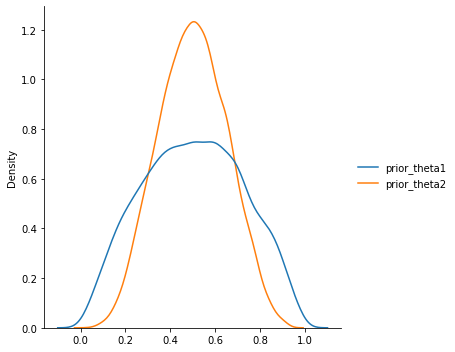

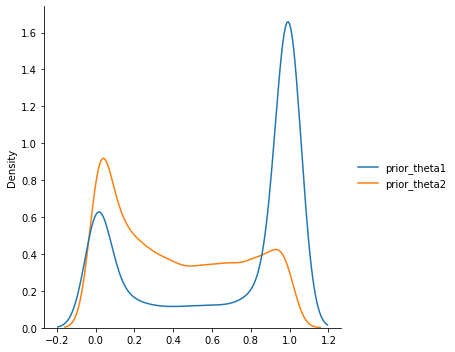

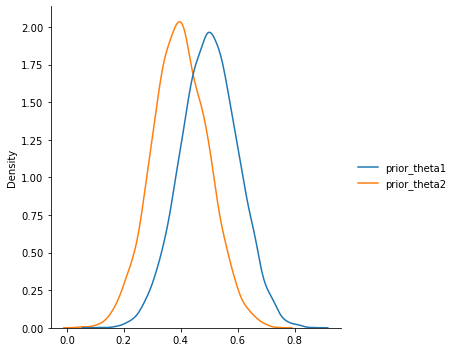

In [147]:
#### Setting up the prior distributions
theta1_beta = dist.Beta(2,2)
theta2_beta = dist.Beta(5,5)
theta1_beta_ = dist.Beta(0.2,0.1)
theta2_beta_ = dist.Beta(0.5,0.7)
theta1_gauss = dist.Normal(0.5,0.1)
theta2_gauss = dist.Normal(0.4,0.1)
plot_dist(theta1_beta, theta2_beta)
plot_dist(theta1_beta_, theta2_beta_)
plot_dist(theta1_gauss, theta2_gauss)


Sample: 100%|██████████| 400/400 [00:08, 47.16it/s, step size=9.85e-01, acc. prob=0.894] 


dict_keys(['theta_1', 'theta_2'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.49      0.24      0.48      0.09      0.83     83.42      0.99
   theta_2      0.80      0.01      0.80      0.79      0.81    105.03      0.99

Number of divergences: 0
None
expected theta1 = 0.4916955530643463
expected theta2 = 0.7986794114112854


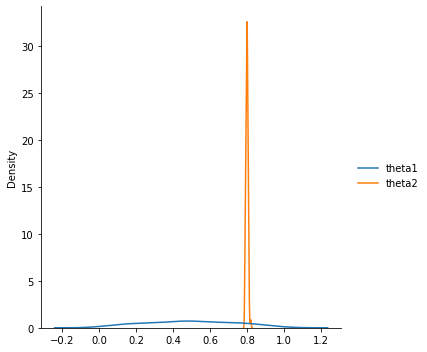

In [133]:
# Launch the MCMC inference with beta prior
Model = pyro.condition(model(theta1_beta, theta2_beta), data={"y":y})
mcmc = compute_mcmc(Model,x, Kernel=NUTS)
plot_inference(mcmc)

Sample: 100%|██████████| 400/400 [00:06, 61.65it/s, step size=6.86e-01, acc. prob=0.929] 


dict_keys(['theta_1', 'theta_2'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.50      0.08      0.49      0.36      0.61     68.40      0.99
   theta_2      0.80      0.00      0.80      0.79      0.81    149.23      0.99

Number of divergences: 0
None
expected theta1 = 0.5012549757957458
expected theta2 = 0.7985023260116577


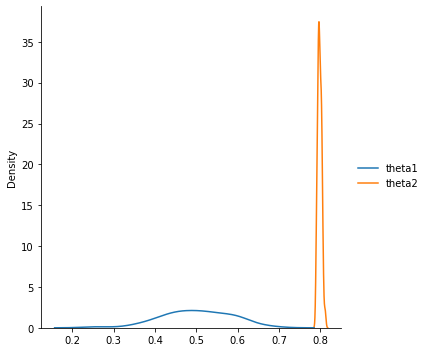

In [136]:
# Launch the MCMC inference with gauss prior
Model = pyro.condition(model(theta1_gauss, theta2_gauss), data={"y":y})
mcmc_gauss = compute_mcmc(Model,x, Kernel=NUTS)
plot_inference(mcmc_gauss)

Sample: 100%|██████████| 400/400 [00:21, 18.31it/s, step size=6.69e-01, acc. prob=0.892]


dict_keys(['theta_1', 'theta_2'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.55      0.44      0.75      0.00      1.00     60.69      1.02
   theta_2      0.80      0.00      0.80      0.79      0.81    104.94      0.99

Number of divergences: 0
None
expected theta1 = 0.5503346920013428
expected theta2 = 0.8006202578544617


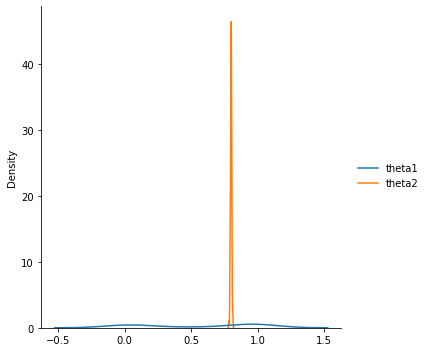

In [148]:
# Launch the MCMC inference with beta prior
Model = pyro.condition(model(theta1_beta_, theta2_beta_), data={"y":y})
mcmc_beta = compute_mcmc(Model,x, Kernel=NUTS)
plot_inference(mcmc_beta)

The main thing that we can osberve is that the posterior distributions of $\theta_1$ is more sensible to change when is used a different prior distribution. In addition, it seems that the chain has more difficult to converge on the parameter $\theta_1$. Also the number of effective samples is smaller for $\theta_1$. This is probably due to the fact that $theta_1$ is less `important` in the equation (it is summed with $x$ that is much greater than $\theta_1$), so it is more sensitive to the prior distribution.

## Ex 2
----

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:
- choose a starting value $p(x_1|x_2^{(0)})$
- for each iteration $i$:
    - draw $x_2(i)$ from $p(x_2|x_1^{(i-1)})$
    - draw $x_1(i)$ from $p(x_1|x_2^{(i)})$

a. Supposing that samples are drawn from a bivariate normal distribution

$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
    implement a Gibbs sampler function which takes as inputs the parameter `rho`, the number of iterations `iters` and the number of warmup draws `warmup`.

b. Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from **Exercise 1**.

----

If 
$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
then 
$$ p(x_1 | x_2 = a) \sim \mathcal{N}[\rho a, 1- r\rho^2] $$

In [1]:
def Gibbs_sampler(rho, iters, warmup):
    ''' Implement Gibbs sampling for bivariate normal distribution'''

    sigma = torch.Tensor([[1,rho], [rho,1]])
    x_2 = 1.1
    x_1 = 0.3
    X_1 = torch.zeros(iters)
    X_2 = torch.zeros(iters)
    for i in range(warmup):
        x_2 = pyro.sample("x_2", dist.Normal(x_1*rho, 1-rho**2))
        x_1 = pyro.sample("x_1", dist.Normal(x_2*rho, 1-rho**2))
    
    for i in range(iters):
        x_2 = pyro.sample("x_2", dist.Normal(x_1*rho, 1-rho**2))
        x_1 = pyro.sample("x_1", dist.Normal(x_2*rho, 1-rho**2))
        X_2[i] = x_2
        X_1[i] = x_1
    
    return X_1, X_2

def plot_gibbs(X1,X2):

    y_1 = np.reshape(X1.numpy(), X1.size()[0])
    y_2 = np.reshape(X2.numpy(), X2.size()[0])
    
    data = pd.DataFrame({"theta1":y_1, "theta2":y_2})
    sns.displot(data, kind="kde")

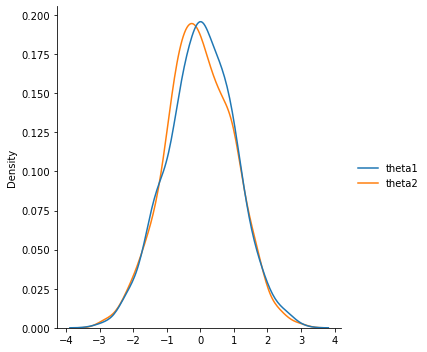

In [20]:
X_1, X_2 = Gibbs_sampler(0.2, 1000, 300)
plot_gibbs(X_1, X_2)